In [32]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import functools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.layers import LSTM
from keras.utils import plot_model
from keras import backend as K
import keras.metrics
import tensorflow as tf


from keras.models import Sequential
from keras.layers import Dense, TimeDistributed
from keras.layers import LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca
from lob_data_utils.svm_calculation import lob_svm
from numpy.random import seed
seed(1)


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_length = 10000
stock = '9062'
gdf_filename_pattern = 'gdf_{}_' + 'len{}'.format(data_length) + '_r{}_s{}_K50'
gdf_parameters = [(1.0, 1.0), (0.1, 0.1), (0.1, 1.0), (1.0, 0.1), (0.01, 0.1)]

In [3]:
df_log = pd.read_csv('../gdf_pca/res_log_que.csv')   
df_log = df_log[df_log['stock'] == int(stock)]
columns = [c for c in df_log.columns if 'matthews' in c or 'roc_auc' in c]
df_log[columns]

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc
17,0.068364,0.534164,0.10818,0.554053,0.071634,0.535742,0.065592,0.532787


In [4]:
def convert_scores_to_df(scores):
    scores2 = []
    for l in scores:
        res = {}
        for k, v in l.items():
            if isinstance(v, list):
                res[k] = np.mean(v)
            else:
                res[k] = v
        scores2.append(res)
    return pd.DataFrame(scores2)

In [5]:
def as_keras_metric(method):
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value

    return wrapper

auc_roc = as_keras_metric(tf.metrics.auc)

In [6]:
gdf_dfs = []
for r, s in gdf_parameters:
    gdf_dfs.append(gdf_pca.SvmGdfResults(
        stock,  r=r, s=s, data_length=data_length, 
        gdf_filename_pattern=gdf_filename_pattern))

## Model 1

In [7]:
model = Sequential()
unit = 20
model.add(LSTM(unit, input_shape=(1, 10)))
model.add(Dense(unit, input_shape=(unit, 1), activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(unit, input_shape=(unit, unit), activation='tanh'))
model.add(Dropout(0.1, input_shape=(unit, unit)))

# model.add(Dropout(0.5, input_shape=(unit, unit)))
model.add(Dense(1, input_shape=(unit, 1), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc])

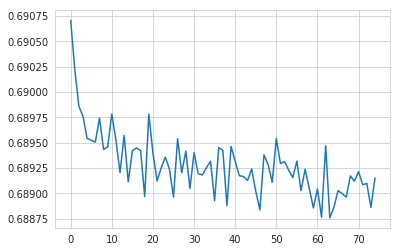

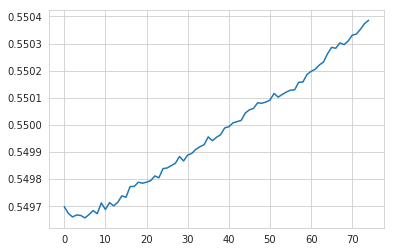

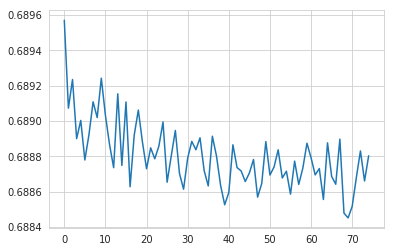

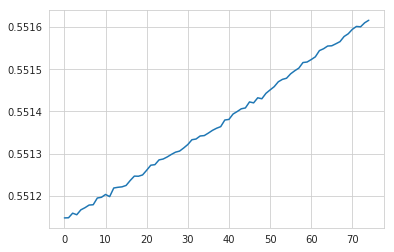

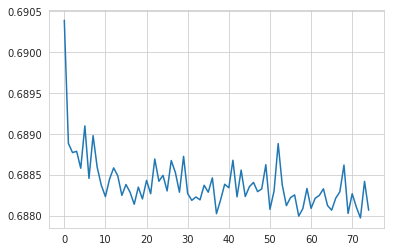

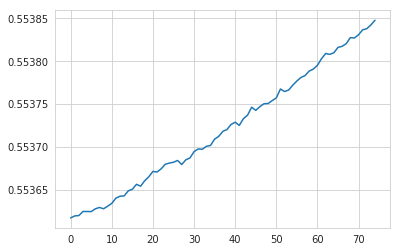

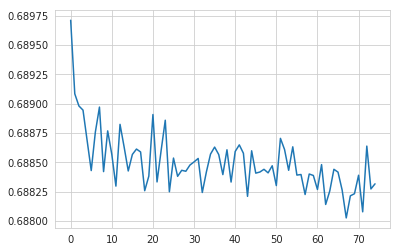

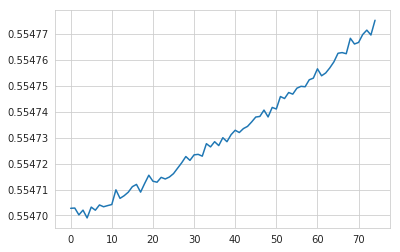

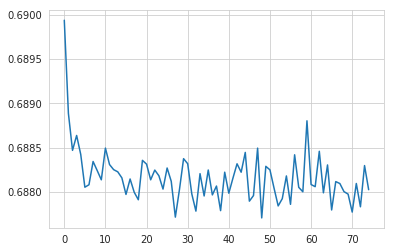

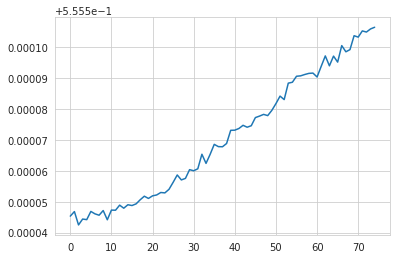

In [8]:
scores = []
epochs = 75
batch_size = 100
for i in range(len(gdf_dfs)):
    score = gdf_dfs[i].train_lstm(model, feature_name='pca_gdf_que_prev10', 
                           fit_kwargs={'epochs': epochs, 'batch_size': batch_size, 'verbose': 0}, 
                                  plot_name='here.png')
    scores.append({**score, 'r': gdf_dfs[i].r, 's': gdf_dfs[i].r, 'stock': gdf_dfs[i].stock, 
                  'epochs': epochs, 'batch_size': batch_size})

In [9]:
df_res = convert_scores_to_df(scores)
df_res[columns + ['r', 's']]

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc,r,s
0,0.059640,0.529501,0.084053,0.541075,0.081735,0.540332,0.069474,0.534564,1.00,1.00
1,0.059710,0.529550,0.085983,0.542829,0.086522,0.543257,0.071372,0.535550,0.10,0.10
2,0.047091,0.523443,0.085234,0.542608,0.084816,0.542401,0.085437,0.542554,0.10,0.10
3,0.045070,0.522384,0.080902,0.540456,0.079294,0.539176,0.086225,0.542805,1.00,1.00
4,0.052097,0.525992,0.074129,0.537065,0.078667,0.539113,0.088797,0.544133,0.01,0.01


In [11]:
df_res.to_csv('9062_model1.csv')

## Model 2

In [10]:
model = Sequential()
unit = 20
model.add(LSTM(20, input_shape=(1, 10)))
model.add(Dense(10, input_shape=(20, 1), activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(10, input_shape=(10, 1), activation='tanh', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dense(1, input_shape=(10, 1), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc])

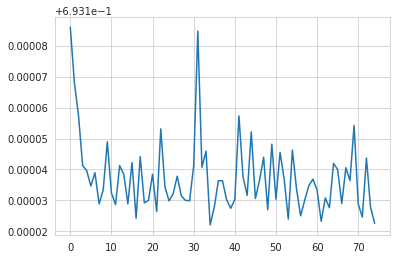

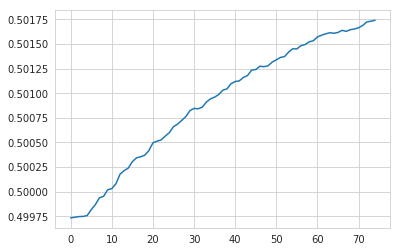

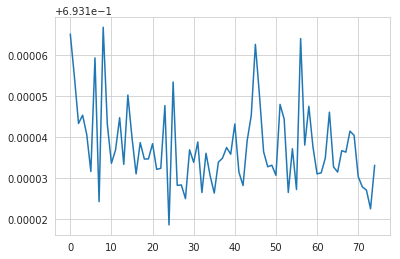

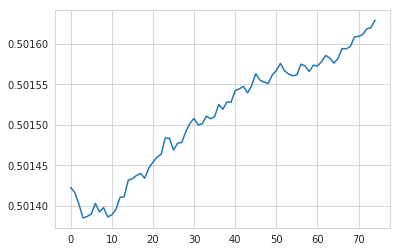

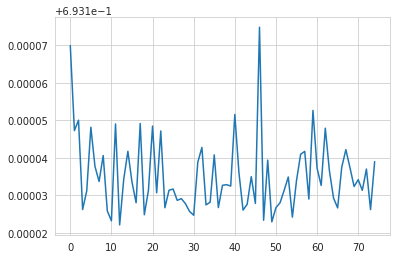

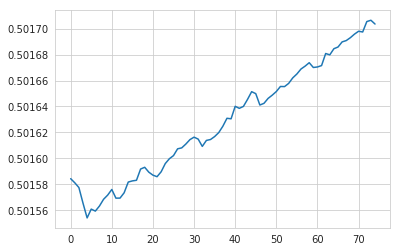

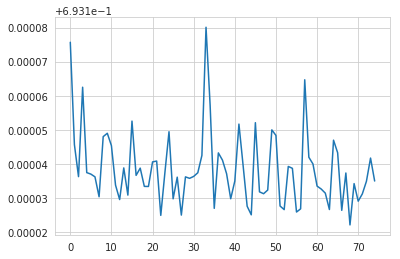

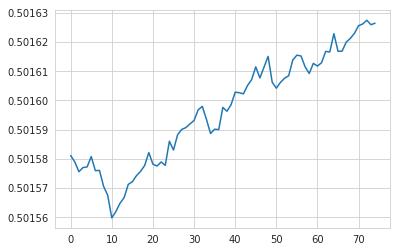

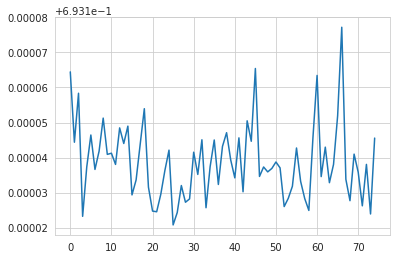

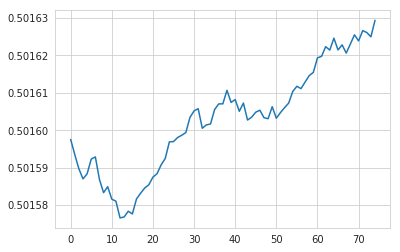

In [12]:
scores = []
epochs = 75
batch_size = 100
for i in range(len(gdf_dfs)):
    score = gdf_dfs[i].train_lstm(model, feature_name='pca_gdf_que_prev10', 
                           fit_kwargs={'epochs': epochs, 'batch_size': batch_size, 'verbose': 0}, 
                                  plot_name='here.png')
    scores.append({**score, 'r': gdf_dfs[i].r, 's': gdf_dfs[i].r, 'stock': gdf_dfs[i].stock, 
                  'epochs': epochs, 'batch_size': batch_size})

In [13]:
df_res = convert_scores_to_df(scores)
df_res[columns + ['r', 's']]

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc,r,s
0,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.00,1.00
1,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,0.10,0.10
2,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,0.10,0.10
3,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.00,1.00
4,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,0.01,0.01


In [14]:
df_res.to_csv('9062_model2.csv')

## Model 3

In [15]:
model = Sequential()
unit = 20
model.add(LSTM(20, input_shape=(1, 10)))
model.add(Dense(10, input_shape=(20, 1), activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(10, input_shape=(10, 1), activation='tanh'))
model.add(Dense(1, input_shape=(10, 1), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc])

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc,r,s
0,0.066315,0.533105,0.091086,0.545541,0.079523,0.539654,0.071226,0.535580,1.00,1.00
1,0.064663,0.532220,0.076603,0.537038,0.085275,0.542456,0.068265,0.534015,0.10,0.10
2,0.049513,0.523671,0.073862,0.536882,0.085131,0.542515,0.090776,0.544650,0.10,0.10
3,0.047978,0.523950,0.061428,0.530672,0.083745,0.541749,0.094074,0.546000,1.00,1.00
4,0.046958,0.522890,0.079814,0.539718,0.081621,0.540798,0.084376,0.539914,0.01,0.01


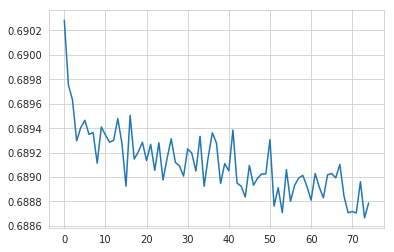

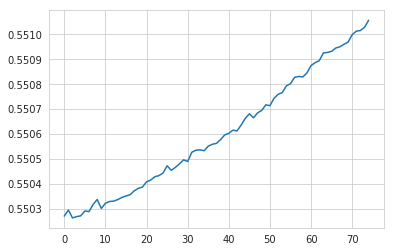

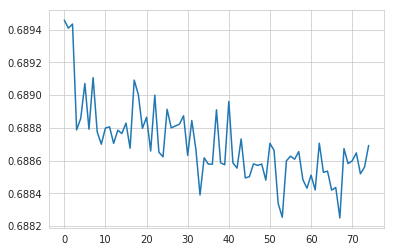

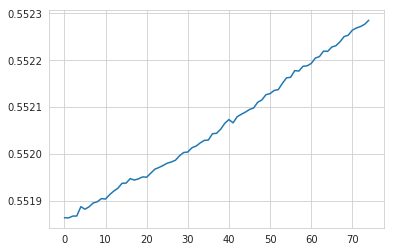

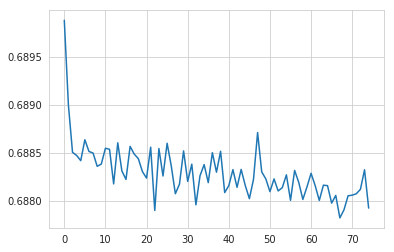

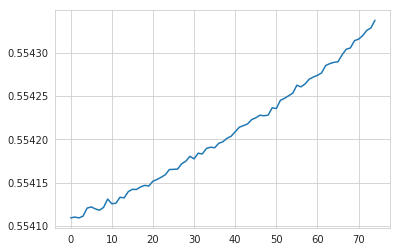

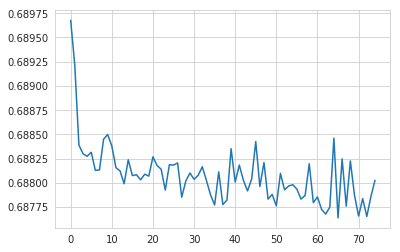

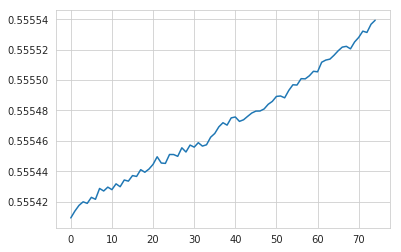

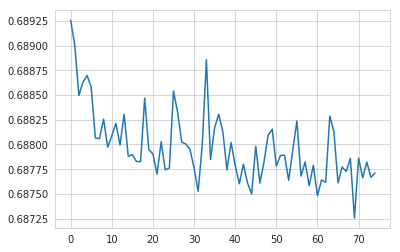

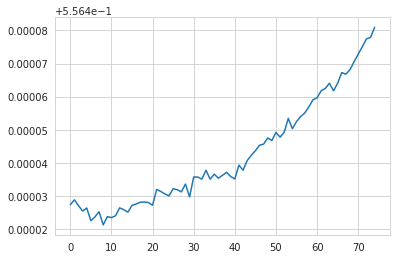

In [16]:
scores = []
epochs = 75
batch_size = 100
for i in range(len(gdf_dfs)):
    score = gdf_dfs[i].train_lstm(model, feature_name='pca_gdf_que_prev10', 
                           fit_kwargs={'epochs': epochs, 'batch_size': batch_size, 'verbose': 0}, 
                                  plot_name='here.png')
    scores.append({**score, 'r': gdf_dfs[i].r, 's': gdf_dfs[i].r, 'stock': gdf_dfs[i].stock, 
                  'epochs': epochs, 'batch_size': batch_size})

In [18]:
df_res = convert_scores_to_df(scores)
df_res[columns + ['r', 's']]

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc,r,s
0,0.066315,0.533105,0.091086,0.545541,0.079523,0.539654,0.071226,0.535580,1.00,1.00
1,0.064663,0.532220,0.076603,0.537038,0.085275,0.542456,0.068265,0.534015,0.10,0.10
2,0.049513,0.523671,0.073862,0.536882,0.085131,0.542515,0.090776,0.544650,0.10,0.10
3,0.047978,0.523950,0.061428,0.530672,0.083745,0.541749,0.094074,0.546000,1.00,1.00
4,0.046958,0.522890,0.079814,0.539718,0.081621,0.540798,0.084376,0.539914,0.01,0.01


In [17]:
df_res.to_csv('9062_model3.csv')

In [ ]:
## Model 4

In [21]:
model = Sequential()
unit = 20
model.add(LSTM(20, input_shape=(1, 10)))
model.add(Dense(10, input_shape=(20, 1), activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(10, input_shape=(10, 1), activation='tanh', activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(1, input_shape=(10, 1), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc])

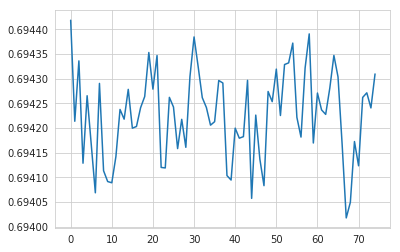

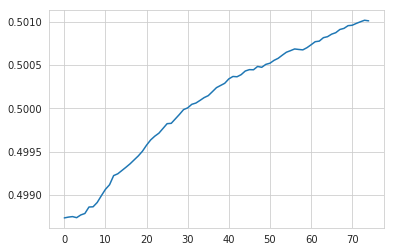

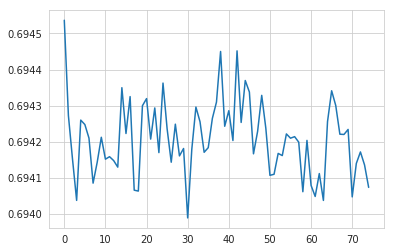

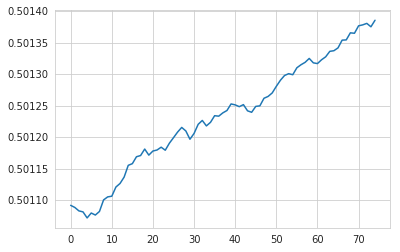

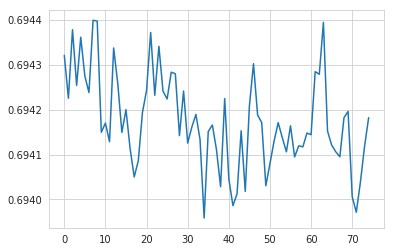

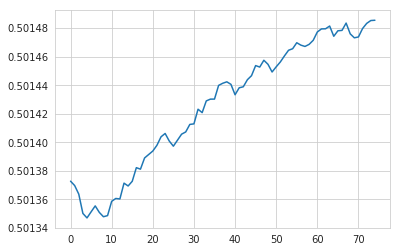

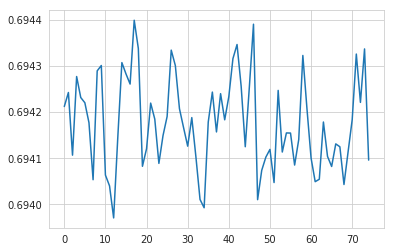

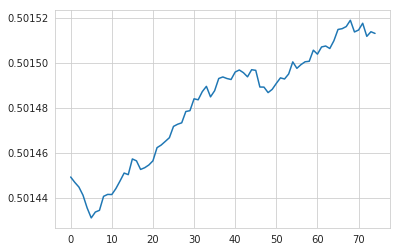

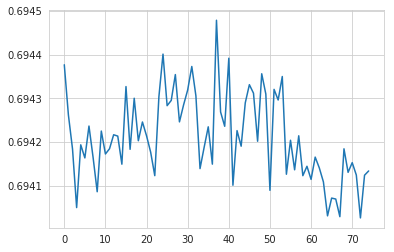

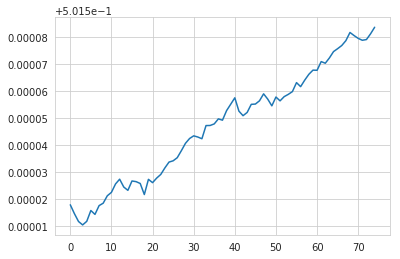

In [22]:
scores = []
epochs = 75
batch_size = 100
for i in range(len(gdf_dfs)):
    score = gdf_dfs[i].train_lstm(model, feature_name='pca_gdf_que_prev10', 
                           fit_kwargs={'epochs': epochs, 'batch_size': batch_size, 'verbose': 0}, 
                                  plot_name='here.png')
    scores.append({**score, 'r': gdf_dfs[i].r, 's': gdf_dfs[i].r, 'stock': gdf_dfs[i].stock, 
                  'epochs': epochs, 'batch_size': batch_size})


In [23]:
df_res = convert_scores_to_df(scores)
df_res[columns + ['r', 's']]

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc,r,s
0,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.00,1.00
1,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,0.10,0.10
2,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,0.10,0.10
3,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,1.00,1.00
4,0.0,0.5,0.0,0.5,0.0,0.5,0.0,0.5,0.01,0.01


In [24]:
df_res.to_csv('9062_model4.csv')

In [ ]:
## Model 5

In [26]:
model = Sequential()
model.add(LSTM(8, input_shape=(1, 10)))
model.add(Dense(8, input_shape=(8, 1), activation='tanh'))
model.add(Dense(4, input_shape=(8, 1), activation='tanh'))
model.add(Dense(1, input_shape=(4, 1), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc])

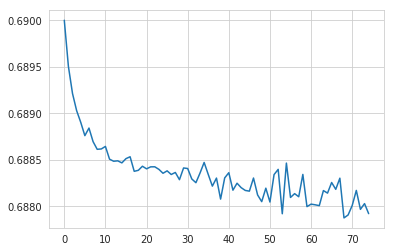

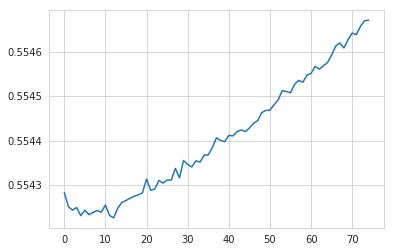

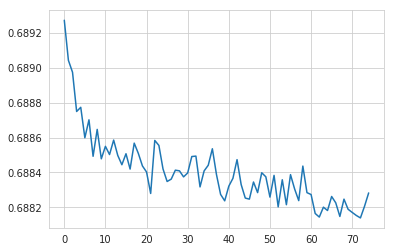

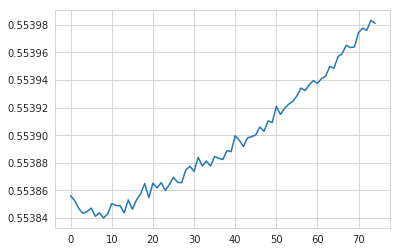

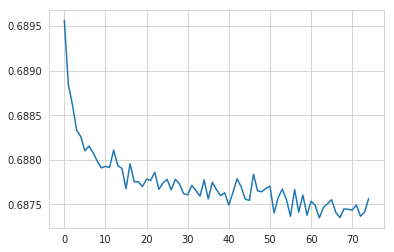

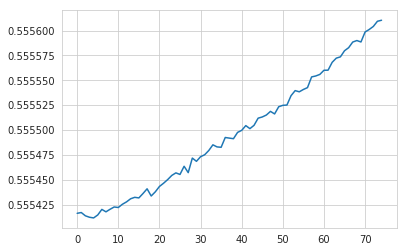

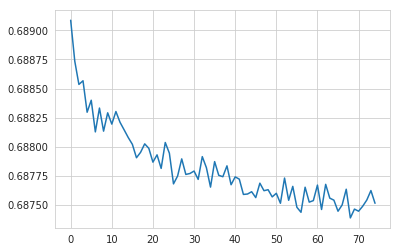

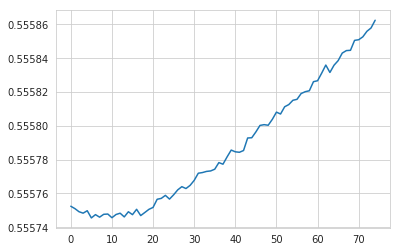

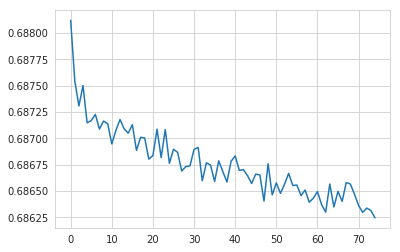

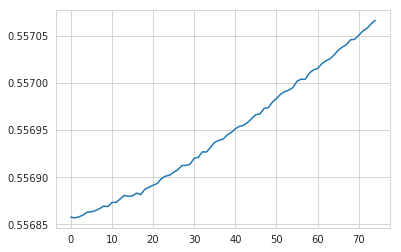

In [27]:
scores = []
epochs = 75
batch_size = 100
for i in range(len(gdf_dfs)):
    score = gdf_dfs[i].train_lstm(model, feature_name='pca_gdf_que_prev10', 
                           fit_kwargs={'epochs': epochs, 'batch_size': batch_size, 'verbose': 0}, 
                                  plot_name='here.png')
    scores.append({**score, 'r': gdf_dfs[i].r, 's': gdf_dfs[i].r, 'stock': gdf_dfs[i].stock, 
                  'epochs': epochs, 'batch_size': batch_size})


In [28]:
df_res = convert_scores_to_df(scores)
df_res[columns + ['r', 's']]

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc,r,s
0,0.058691,0.529245,0.092286,0.546042,0.085046,0.542521,0.077364,0.538634,1.00,1.00
1,0.068911,0.534267,0.068371,0.533163,0.087099,0.543493,0.069192,0.534559,0.10,0.10
2,0.051247,0.525457,0.085331,0.542651,0.078102,0.539052,0.088626,0.544217,0.10,0.10
3,0.050320,0.525127,0.072103,0.535951,0.087317,0.543651,0.071185,0.535537,1.00,1.00
4,0.053683,0.526632,0.085983,0.542829,0.095649,0.547807,0.084120,0.542000,0.01,0.01


In [29]:
df_res.to_csv('9062_model5.csv')

In [ ]:
## Model 6  metrics=['matthews_correlation']

In [39]:
model = Sequential()
model.add(LSTM(8, input_shape=(1, 10)))
model.add(Dense(8, input_shape=(8, 1), activation='tanh', activity_regularizer=regularizers.l2(0.01)))
model.add(Dense(4, input_shape=(8, 1), activation='tanh', activity_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, input_shape=(4, 1), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc])

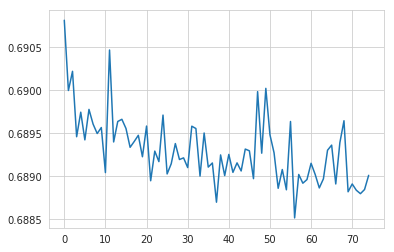

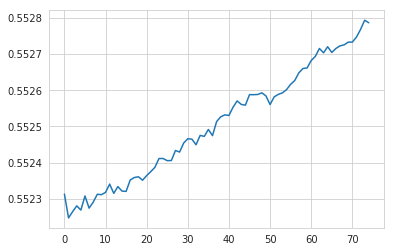

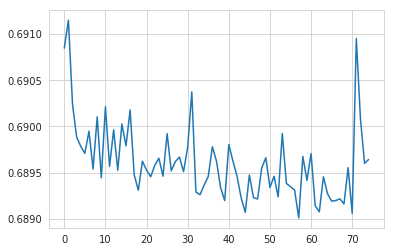

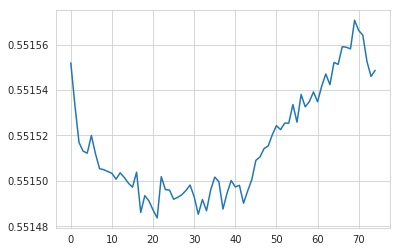

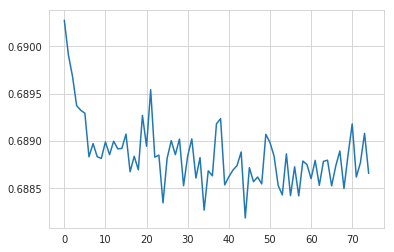

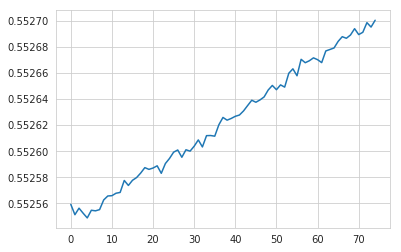

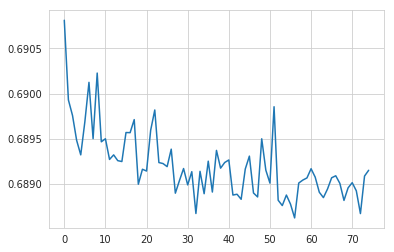

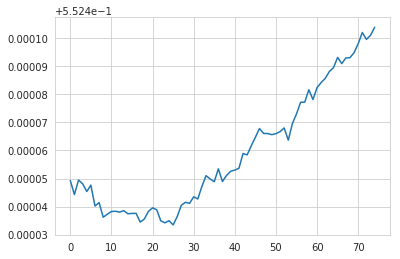

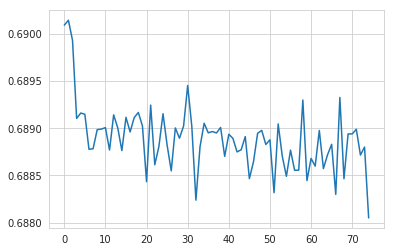

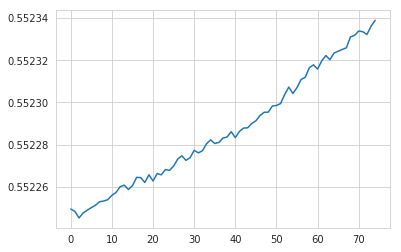

In [40]:
scores = []
epochs = 75
batch_size = 100
for i in range(len(gdf_dfs)):
    score = gdf_dfs[i].train_lstm(model, feature_name='pca_gdf_que_prev10', 
                           fit_kwargs={'epochs': epochs, 'batch_size': batch_size, 'verbose': 0}, 
                                  plot_name='here.png')
    scores.append({**score, 'r': gdf_dfs[i].r, 's': gdf_dfs[i].r, 'stock': gdf_dfs[i].stock, 
                  'epochs': epochs, 'batch_size': batch_size})


In [41]:
df_res = convert_scores_to_df(scores)
df_res[columns + ['r', 's']]

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc,r,s
0,0.058850,0.528518,0.077121,0.535791,0.088978,0.541694,0.085671,0.541220,1.00,1.00
1,0.056686,0.527958,0.087179,0.542968,0.085707,0.542853,0.066737,0.533153,0.10,0.10
2,0.060074,0.529161,0.082816,0.540170,0.076901,0.537197,0.085658,0.542244,0.10,0.10
3,0.056027,0.527333,0.076629,0.533625,0.082275,0.539455,0.071860,0.535246,1.00,1.00
4,0.056985,0.527600,0.067199,0.532157,0.081258,0.540461,0.061272,0.529259,0.01,0.01


In [44]:
df_res.to_csv('9062_model6.csv')

In [ ]:
## Model 7

In [45]:
model = Sequential()
model.add(LSTM(8, input_shape=(1, 10)))
model.add(Dense(8, input_shape=(8, 1), activation='tanh', activity_regularizer=regularizers.l2(0.01)))
model.add(Dense(4, input_shape=(8, 1), activation='tanh', activity_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, input_shape=(4, 1), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc_roc])

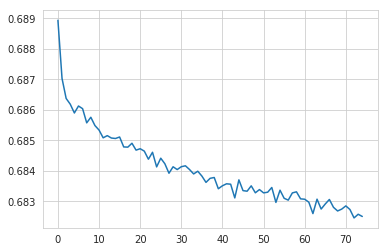

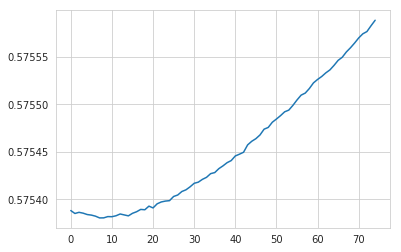

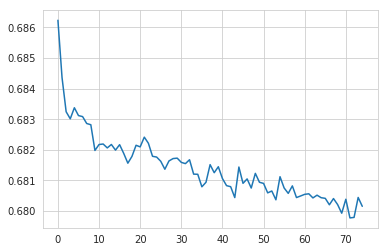

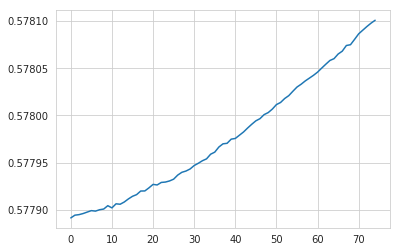

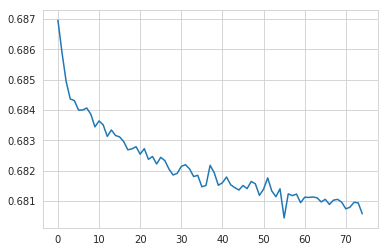

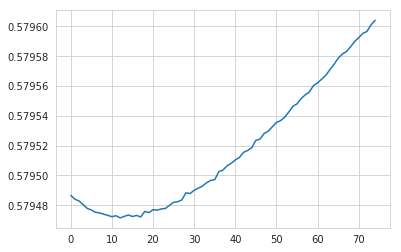

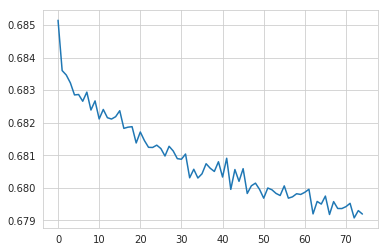

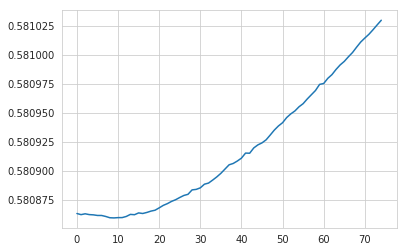

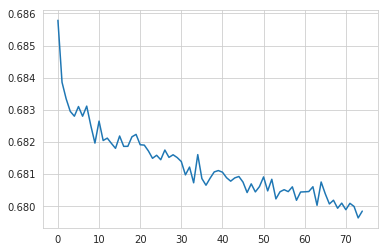

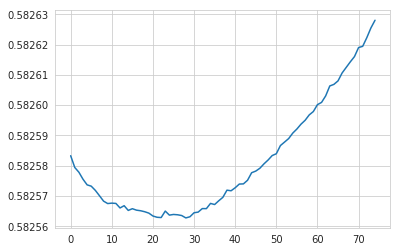

In [47]:
scores = []
epochs = 75
batch_size = 10
for i in range(len(gdf_dfs)):
    score = gdf_dfs[i].train_lstm(model, feature_name='pca_gdf_que_prev10', 
                           fit_kwargs={'epochs': epochs, 'batch_size': batch_size, 'verbose': 0}, 
                                  plot_name='here.png')
    scores.append({**score, 'r': gdf_dfs[i].r, 's': gdf_dfs[i].r, 'stock': gdf_dfs[i].stock, 
                  'epochs': epochs, 'batch_size': batch_size})


In [48]:
df_res = convert_scores_to_df(scores)
df_res[columns + ['r', 's']]

,matthews,roc_auc,test_matthews,test_roc_auc,train_matthews,train_roc_auc,train_val_matthews,train_val_roc_auc,r,s
0,0.031636,0.515720,0.020834,0.510232,0.135040,0.566342,0.140955,0.570147,1.00,1.00
1,0.072154,0.535583,0.037438,0.518455,0.131669,0.565669,0.148492,0.573593,0.10,0.10
2,0.030405,0.514557,0.056194,0.528100,0.128896,0.564381,0.137717,0.565665,0.10,0.10
3,0.061996,0.530730,0.064898,0.532308,0.144249,0.570822,0.149487,0.573812,1.00,1.00
4,0.048068,0.523841,0.037512,0.517139,0.143895,0.564675,0.159270,0.578667,0.01,0.01


In [49]:
df_res.to_csv('9062_model7.csv')